In [1]:
# Add mooncake to sys

import sys

mooncake_path = '/Users/ramonamezquita/Projects/mooncake'
sys.path.append(mooncake_path)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Modules

import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from mooncake.preprocessing import GroupTransformer
from mooncake.preprocessing import TimeIndex
from mooncake.preprocessing import ColumnTransformer
from mooncake.preprocessing import CyclicalDates
from mooncake.helper import column_selector

In [4]:
def select_top_n_groups(X, n, group_ids, wrt, aggfunc=sum):
    top_group_ids =  X.groupby(
        group_ids).agg({wrt: aggfunc}).nlargest(n, wrt).index.tolist()
    
    return X.set_index(group_ids).loc[top_group_ids].reset_index()

In [5]:
# Data and description

X = pd.read_csv('sales_forecasting_dataset.csv')
date = 'Date'
group_ids = ['Store', 'Dept']
target = 'Weekly_Sales'

# Send group ids to object dtype
for g in group_ids:
    X[g] = X[g].astype(str)

In [6]:
n_groups_to_use = 20
X = select_top_n_groups(X, n_groups_to_use, group_ids, target)
X.sort_values(group_ids + [date], inplace=True)

In [7]:
# Add time index

X[date] = pd.to_datetime(X[date])
X['time_idx'] = X[date].copy()
time_index_transformer = GroupTransformer(
    transformers=[('time_idx', TimeIndex(), 'time_idx')],
    group_ids=group_ids
)
X = time_index_transformer.fit_transform(X)

In [8]:
# Split

from mooncake.model_selection import train_test_split

test_start = '2012-10-01'
test_end = '2012-12-10'
freq = 'W'
prediction_length = len(pd.date_range(test_start, test_end, freq=freq))
max_encoder_length = 2 * prediction_length
X_train, X_test = train_test_split(
    X, 
    test_start, 
    test_end, 
    date, 
    freq=freq, 
    sequence_length=max_encoder_length
)

In [10]:
# Group transformer
num_selector = column_selector(dtype_include=(int, float), pattern_exclude='time_idx')
group_transformers = [
    ('num', MinMaxScaler(), num_selector)
]
group_transformer = GroupTransformer(group_transformers, group_ids=group_ids)

# Outer transformer
cat_selector = column_selector(dtype_include=(object, bool), pattern_exclude=group_ids)
outer_transformer = [
    ('cat', OneHotEncoder(drop='if_binary'), cat_selector),
    ('cyclic_dates', CyclicalDates(), date)
]
outer_transformer = ColumnTransformer(outer_transformer)


# preprocessor
preprocessor = Pipeline(
    steps=[
        ('group_transformer', group_transformer),
        ('outer_transformer', outer_transformer)
    ]
)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Train

## seq2seq

In [10]:
from mooncake.nn import SeqToSeq
from mooncake.helper import common_callbacks
from torch.optim.lr_scheduler import OneCycleLR

In [10]:
# Fit

column_segmentation = {
    'static_categoricals': group_ids,
    'time_varying_unknown_reals': ['Weekly_Sales'],
    'time_varying_known_reals': ['x0_True', 'day_sine', 'day_cos', 'month_sine', 'month_cos']
}
lr_scheduler = {
        'policy': OneCycleLR,
        'step_every': 'batch',
        'max_lr': 1e-3,
        'steps_per_epoch': 'iterations',
        'epochs': 'max_epochs'
    }
callbacks = common_callbacks(
    lr_scheduler, 
    gradient_clipping=True,
    early_stopping=True, 
    patience=20
)

estimator = SeqToSeq(
    group_ids=group_ids,
    time_idx='time_idx',
    target=target,
    max_prediction_length=prediction_length,
    max_encoder_length=prediction_length,
    cv_split=X_test_transformed,
    batch_size=128,
    max_epochs=100,
    callbacks=callbacks,
    hidden_size=64,
    **column_segmentation
)

In [11]:
estimator.get_kwargs_for('module')

init module params: OrderedDict([('self', <Parameter "self">), ('emb_dim', <Parameter "emb_dim">), ('emb_sizes', <Parameter "emb_sizes">), ('enc_size', <Parameter "enc_size">), ('dec_size', <Parameter "dec_size">), ('hidden_size', <Parameter "hidden_size">), ('tf_ratio', <Parameter "tf_ratio=0.2">), ('cell_type', <Parameter "cell_type='lstm'">)])


{'emb_dim': 10, 'hidden_size': 64, 'tf_ratio': 0.2, 'cell_type': 'lstm'}

In [11]:
estimator.fit(X=X_train_transformed)

/Users/ramonamezquita/Projects/mooncake/mooncake/nn/datasets.py:427: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 248 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'Store': 0, 'Dept': 60}, {'Store': 0, 'Dept': 61}, {'Store': 1, 'Dept': 45}, {'Store': 1, 'Dept': 60}, {'Store': 1, 'Dept': 61}, {'Store': 2, 'Dept': 41}, {'Store': 2, 'Dept': 44}, {'Store': 2, 'Dept': 60}, {'Store': 2, 'Dept': 61}, {'Store': 3, 'Dept': 45}]
  warnings.warn(
/Users/ramonamezquita/Projects/mooncake/mooncake/nn/datasets.py:427: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 309 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'Store': 0, 'Dept': 8}, {'Store': 0, 'Dept

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.2093        0.1577  75.9912
      2        0.1763        0.1562  75.4277
      3        0.1658        0.1578  75.0227
      4        0.1513        0.1573  74.7319
      5        0.1455        0.1600  74.5629
      6        0.1478        0.1559  1427.9723
      7        0.1481        0.1611  76.3058
      8        0.1466        0.1583  76.2975
      9        0.1479        0.1565  74.7894
     10        0.1466        0.1566  74.4899
     11        0.1455        0.1611  75.0949
     12        0.1439        0.1575  74.8111
     13        0.1429        0.1606  76.3350
     14        0.1381        0.1670  76.8377
     15        0.1375        0.1603  77.2787
     16        0.1373        0.1573  77.6444


SeqToSeq(batch_size=128,
         callbacks=[('lr_scheduler',
                     <skorch.callbacks.lr_scheduler.LRScheduler object at 0x299369400>),
                    ('early_stopping',
                     <skorch.callbacks.training.EarlyStopping object at 0x299369700>),
                    ('gradient_clipping',
                     <skorch.callbacks.regularization.GradientNormClipping object at 0x2993693d0>)],
         criterion=<class 'pytorch_forecasting.metrics.RMSE'>,
         cv_spl...
         group_ids=['Store', 'Dept'], hidden_size=64, max_encoder_length=10,
         max_epochs=100, max_prediction_length=10,
         optimizer=<class 'torch.optim.adam.Adam'>,
         static_categoricals=['Store', 'Dept'], target='Weekly_Sales',
         time_idx='time_idx',
         time_varying_known_reals=['x0_True', 'day_sine', 'day_cos',
                                   'month_sine', 'month_cos'],
         time_varying_unknown_reals=['Weekly_Sales'])

In [86]:
yhat_train = estimator.predict(
    X_train_transformed, 
    raw=False, 
    inverse_transformer=preprocessor
)
yhat_test = estimator.predict(
    X_test_transformed, 
    raw=False, 
    inverse_transformer=preprocessor
)

/Users/ramonamezquita/Projects/mooncake/mooncake/nn/datasets.py:427: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 248 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'Store': 0, 'Dept': 60}, {'Store': 0, 'Dept': 61}, {'Store': 1, 'Dept': 45}, {'Store': 1, 'Dept': 60}, {'Store': 1, 'Dept': 61}, {'Store': 2, 'Dept': 41}, {'Store': 2, 'Dept': 44}, {'Store': 2, 'Dept': 60}, {'Store': 2, 'Dept': 61}, {'Store': 3, 'Dept': 45}]
  warnings.warn(
/Users/ramonamezquita/Projects/mooncake/mooncake/nn/datasets.py:427: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 309 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'Store': 0, 'Dept': 8}, {'Store': 0, 'Dept

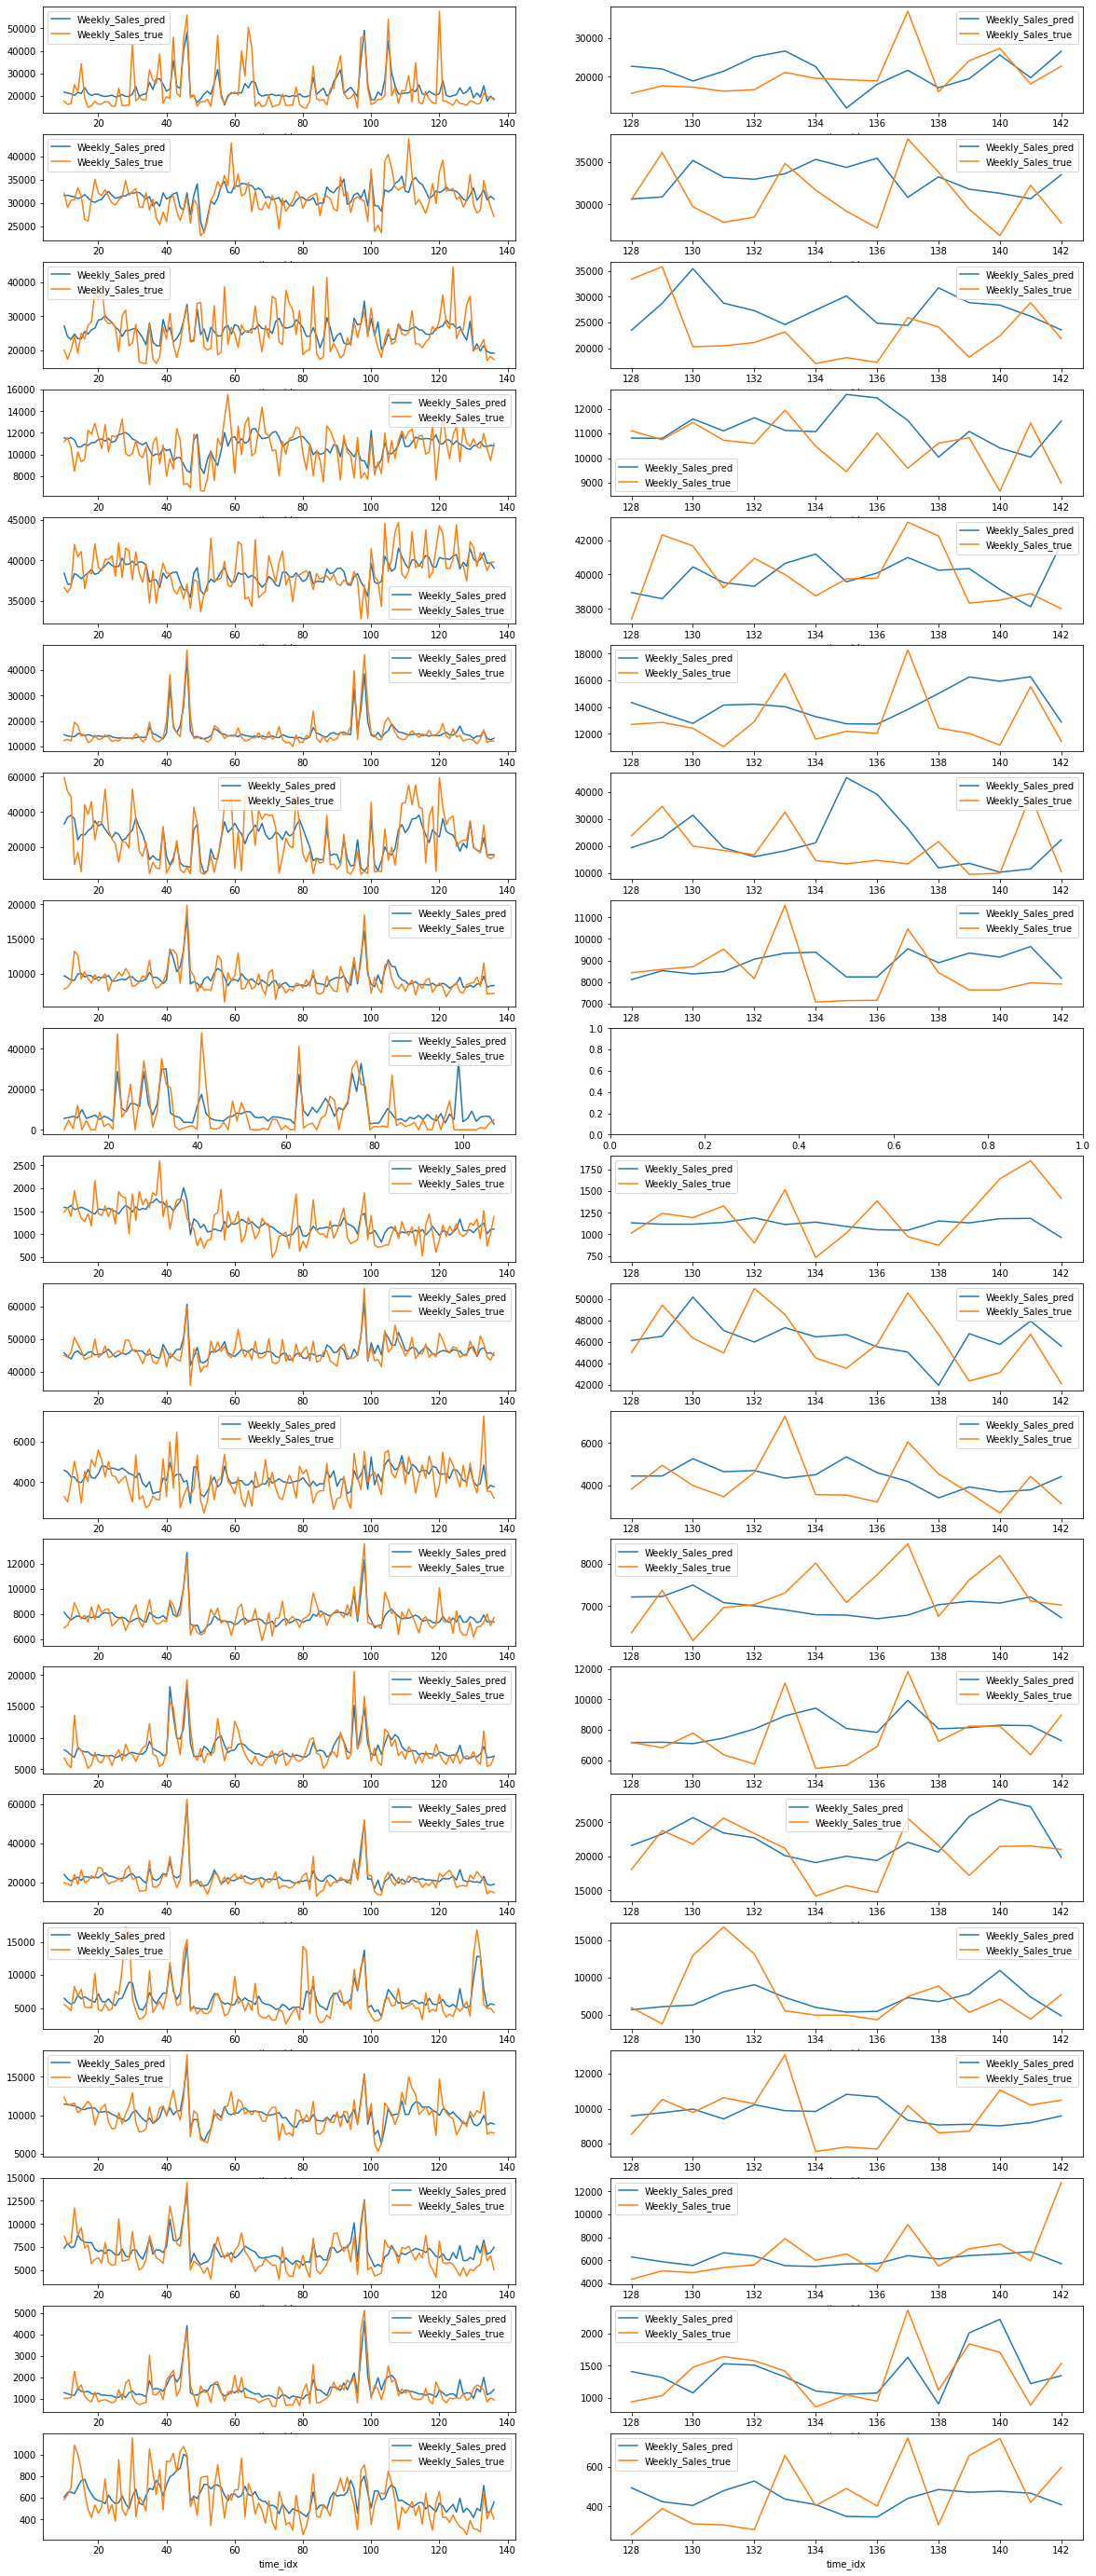

In [87]:
n = 20
groupby_train = yhat_train.groupby(group_ids)
groupby_test = yhat_test.groupby(group_ids)
fig, axs = plt.subplots(n, 2, figsize=(20, 50))
axs = axs.flatten()
i = 0
for i, g in enumerate(groupby_train.groups):
    if i >= n :
        break
    ax_l = axs[2 * i]
    ax_r = axs[2 * i + 1]
    try:
        groupby_train.get_group(g).set_index('time_idx').plot(ax=ax_l)
        groupby_test.get_group(g).set_index('time_idx').plot(ax=ax_r)
    except KeyError:
        continue
    
    i += 1
    

## Temporal fusion transformer (tft)

In [44]:
from mooncake.nn import TemporalFusionTransformer as TFT

In [48]:
# Fit

column_segmentation = {
    'static_categoricals': group_ids,
    'time_varying_unknown_reals': ['Weekly_Sales'],
    'time_varying_known_reals': ['x0_True', 'day_sine', 'day_cos', 'month_sine', 'month_cos']
}
lr_scheduler = {
        'policy': OneCycleLR,
        'step_every': 'batch',
        'max_lr': 1e-3,
        'steps_per_epoch': 'iterations',
        'epochs': 'max_epochs'
    }
callbacks = common_callbacks(
    lr_scheduler, 
    gradient_clipping=True,
    early_stopping=True, 
    patience=20
)

estimator = TFT(
    group_ids=group_ids,
    time_idx='time_idx',
    target=target,
    max_prediction_length=prediction_length,
    max_encoder_length=prediction_length,
    cv_split=X_test_transformed,
    batch_size=128,
    max_epochs=3,
    callbacks=callbacks,
    hidden_size=64,
    output_size=1,
    **column_segmentation
)

In [49]:
estimator.fit(X_train_transformed)

/Users/ramonamezquita/Projects/mooncake/mooncake-venv/lib/python3.9/site-packages/pytorch_forecasting/data/timeseries.py:1238: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 248 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__Store': '1', '__group_id__Dept': '77'}, {'__group_id__Store': '1', '__group_id__Dept': '78'}, {'__group_id__Store': '10', '__group_id__Dept': '51'}, {'__group_id__Store': '10', '__group_id__Dept': '77'}, {'__group_id__Store': '10', '__group_id__Dept': '78'}, {'__group_id__Store': '11', '__group_id__Dept': '48'}, {'__group_id__Store': '11', '__group_id__Dept': '50'}, {'__group_id__Store': '11', '__group_id__Dept': '77'}, {'__group_id__Store': '11', '__group_id__Dept': '78'}, {'__group_id__Store': '12', '__group_id__Dept': '51'}]
  warnings.warn(
/Users/ramonamezquita/Projects/moonca

  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        0.1857        0.1585  235.5410
      2        0.1488        0.1543  247.0046
      3        0.1406        0.1539  283.1342


TemporalFusionTransformer(batch_size=128,
                          callbacks=[('lr_scheduler',
                                      <skorch.callbacks.lr_scheduler.LRScheduler object at 0x28a93aee0>),
                                     ('early_stopping',
                                      <skorch.callbacks.training.EarlyStopping object at 0x28a93aeb0>),
                                     ('gradient_clipping',
                                      <skorch.callbacks.regularization.GradientNormClipping object at 0x28a93a3d0>)],
                          criterion=<class 'pytorch_forecasting.metr...
                          group_ids=['Store', 'Dept'], hidden_size=64,
                          max_encoder_length=10, max_epochs=3,
                          max_prediction_length=10,
                          optimizer=<class 'torch.optim.adam.Adam'>,
                          output_size=1, static_categoricals=['Store', 'Dept'],
                          target='Weekly_Sales', time_

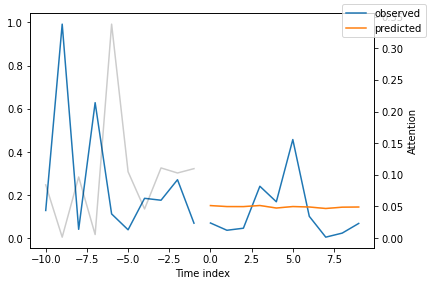

In [53]:
estimator.plot_prediction(X_train_transformed, idx=0)